In [ ]:
# Neue Testanfragen, die Einflussbeziehungen nutzen
expected_langs = [
    {
        "standard_query": "*:*",
        "facets": ["influenced_by", "influenced"],
    },
]

In [53]:
import requests

def run_solr_query_post(case, solr_url, rows=30, facets=None, **additional_params):
    payload = {
        "rows": rows,
        "wt": "json"
    }

    # Enable facets if provided
    if facets:
        payload["facet"] = "true"
        for f in facets:
            payload.setdefault("facet.field", [])
            payload["facet.field"].append(f)
            
        # Optional: Add facet settings for relationship fields
        if "influenced_by" in facets or "influenced" in facets:
            payload["facet.mincount"] = 1  # Only show facets with at least one document
            payload["f.influenced_by.facet.limit"] = 30  # Show more values for these fields
            payload["f.influenced.facet.limit"] = 30
    
    # Handle filter queries for facet refinement
    if 'filter_query' in case and case['filter_query']:
        payload['fq'] = case['filter_query']
        
    # Rest of your existing code...
    payload["q"] = case.get('standard_query') or case.get('query')
    
    # Send to Solr
    resp = requests.post(solr_url, data=payload)
    resp.raise_for_status()
    data = resp.json()
    
    # Return both docs and facets
    docs = data["response"]["docs"]
    facets = data.get("facet_counts", {})
    return docs, facets, payload

In [54]:
import networkx as nx
import matplotlib.pyplot as plt

def build_language_graph(docs):
    """Erstellt einen Wissensgraphen nur aus 'influenced_by'-Beziehungen."""
    G = nx.DiGraph()
    
    # step = 0
    # Knoten und Kanten hinzufügen
    for doc in docs:
        # step += 1
        # if step > 10:
        #     break
        lang_name = doc.get('title', '').replace(' (programming language)', '')
        G.add_node(lang_name)
        
        # Nur "influenced_by"-Beziehungen hinzufügen
        if 'influenced_by' in doc:
            influences = doc['influenced_by']

            influences = [infl.strip() for infl in influences.split(',')]
            
            if len(influences) <= 1:
                print(f"Only one influence found for {lang_name}: {influences}")
            
            for influence in influences:
                G.add_node(influence)
                G.add_edge(influence, lang_name)  # Richtung: A beeinflusst B
    
    return G

def visualize_language_graph(G, title="Programmiersprachen-Beziehungsgraph"):
    """Visualisiert den Wissensgraphen mit Legende und Referenzen."""
    plt.figure(figsize=(16, 14))  # Größere Grafik für mehr Platz
    
    # Verschiedene Knotentypen nach Einfluss klassifizieren
    high_influence = [n for n, d in G.out_degree() if d > 5]
    medium_influence = [n for n, d in G.out_degree() if 2 < d <= 5]
    low_influence = [n for n, d in G.out_degree() if d <= 2]
    
    pos = nx.spring_layout(G, seed=42, k=0.25)  # Layout-Parameter für mehr Abstand
    
    # Knoten mit unterschiedlichen Farben zeichnen
    nx.draw_networkx_nodes(G, pos, nodelist=high_influence, 
                          node_size=1000, node_color="red", 
                          label="Hoher Einfluss (>5)")
    nx.draw_networkx_nodes(G, pos, nodelist=medium_influence, 
                          node_size=800, node_color="orange",
                          label="Mittlerer Einfluss (3-5)")
    nx.draw_networkx_nodes(G, pos, nodelist=low_influence, 
                          node_size=600, node_color="lightblue",
                          label="Geringer Einfluss (≤2)")
    
    # Kanten zeichnen
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.6, 
                         edge_color="gray", arrows=True)
    
    # Labels größer und besser lesbar darstellen
    nx.draw_networkx_labels(G, pos, font_size=14, font_weight='bold',
                           bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
    
    plt.title(title, fontsize=18)
    plt.axis('off')
    
    # Legende hinzufügen
    plt.legend(scatterpoints=1, loc='lower right', fontsize=12)
    
    # Referenzen als Text hinzufügen
    reference_text = (
        "Referenzen:\n"
        "1. Daten aus Solr-Index ProgLang24_5\n"
        "2. Beziehungen basierend nur auf 'influenced_by' Feldern\n"
        "3. Pfeilrichtung: Sprache A → Sprache B bedeutet 'A beeinflusst B'\n"
        "4. Knotenfarbe zeigt Einflussgrad (Anzahl beeinflusster Sprachen)"
    )
    plt.figtext(0.01, 0.01, reference_text, fontsize=10, 
               bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return plt

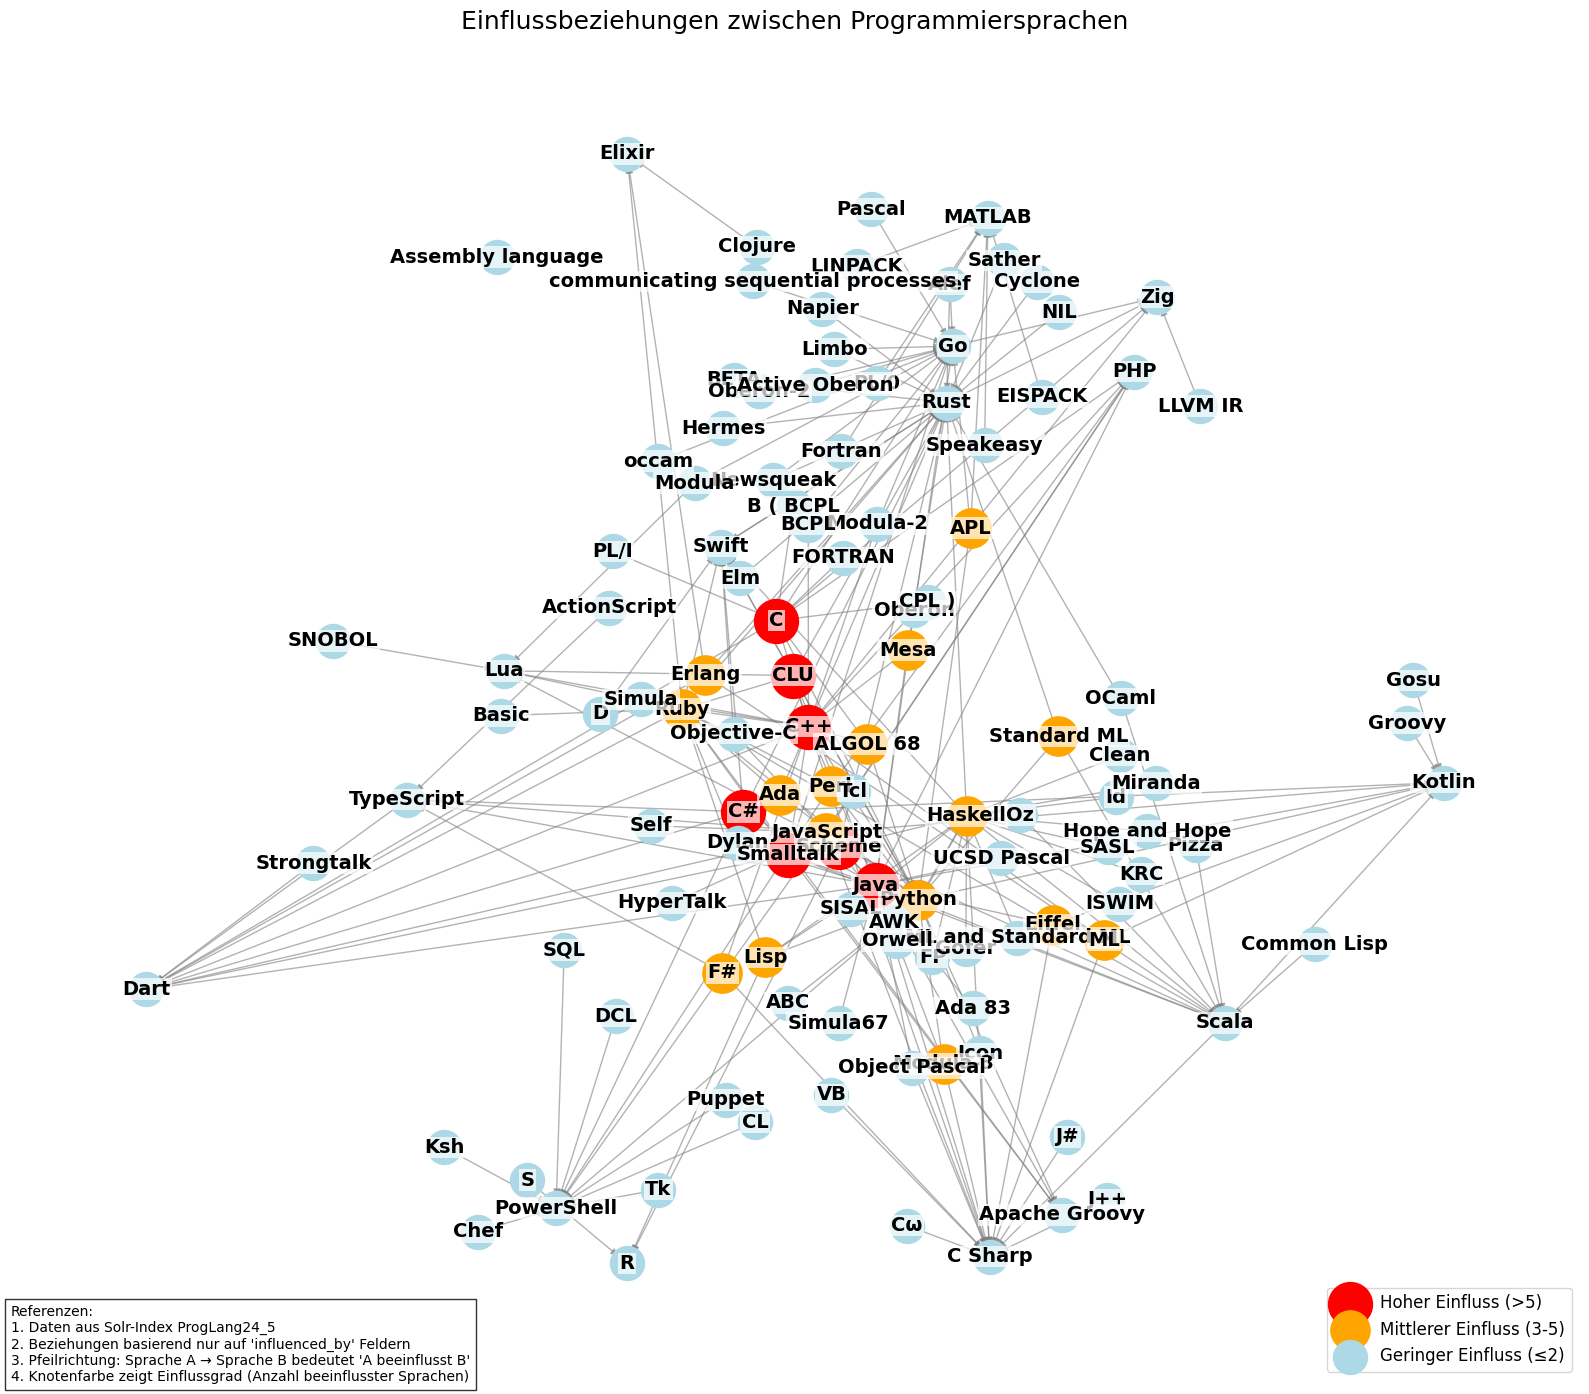

Anzahl Programmiersprachen (Knoten): 118
Anzahl Beziehungen (Kanten): 211

Einflussreichste Sprachen:
C++: 9 beeinflusste Sprachen
Java: 8 beeinflusste Sprachen
CLU: 7 beeinflusste Sprachen
C#: 7 beeinflusste Sprachen
Smalltalk: 7 beeinflusste Sprachen
Scheme: 6 beeinflusste Sprachen
C: 6 beeinflusste Sprachen
Ruby: 5 beeinflusste Sprachen
Haskell: 5 beeinflusste Sprachen
Python: 5 beeinflusste Sprachen

Sprachen mit den meisten Einflüssen:
Rust: 21 Einflüsse
Go: 15 Einflüsse
C Sharp: 15 Einflüsse
Haskell: 14 Einflüsse
Python: 14 Einflüsse
Java: 14 Einflüsse
Ruby: 11 Einflüsse
C++: 11 Einflüsse
Scala: 11 Einflüsse
PowerShell: 11 Einflüsse


In [55]:
# Beispiel zur Nutzung des Wissensgraphen
# from core import run_solr_query_post

# Alle Sprachen abrufen, um den kompletten Graphen zu erstellen
solr_url = f'http://10.248.16.116:8983/solr/ProgLang24_5/select'
docs, facets, _ = run_solr_query_post({"standard_query": "*:*"}, solr_url, rows=100)

# Graphen erstellen und visualisieren
G = build_language_graph(docs)
visualize_language_graph(G, "Einflussbeziehungen zwischen Programmiersprachen")

# Informationen zum Graphen ausgeben
print(f"Anzahl Programmiersprachen (Knoten): {G.number_of_nodes()}")
print(f"Anzahl Beziehungen (Kanten): {G.number_of_edges()}")

# Die einflussreichsten Sprachen finden (höchste Ausgangsgrade)
influential = sorted([(n, G.out_degree(n)) for n in G.nodes()], 
                    key=lambda x: x[1], reverse=True)
print("\nEinflussreichste Sprachen:")
for lang, degree in influential[:10]:
    print(f"{lang}: {degree} beeinflusste Sprachen")

# Sprachen mit den meisten Einflüssen (höchste Eingangsgrade)
influenced = sorted([(n, G.in_degree(n)) for n in G.nodes()], 
                   key=lambda x: x[1], reverse=True)
print("\nSprachen mit den meisten Einflüssen:")
for lang, degree in influenced[:10]:
    print(f"{lang}: {degree} Einflüsse")

In [56]:
# Neue Zelle hinzufügen:
!pip install pyvis

def create_interactive_graph(G, output_file='programming_languages_graph.html'):
    """Erstellt eine interaktive HTML-Visualisierung des Graphen mit Zoom-Funktion."""
    from pyvis.network import Network
    
    # Netzwerk erstellen
    net = Network(height="800px", width="100%", notebook=True, directed=True)
    
    # Knotengruppen basierend auf Einflussgrad definieren
    high_influence = [n for n, d in G.out_degree() if d > 5]
    medium_influence = [n for n, d in G.out_degree() if 2 < d <= 5]
    low_influence = [n for n, d in G.out_degree() if d <= 2]
    
    # Knoten hinzufügen mit verschiedenen Farben je nach Einflussgrad
    for node in G.nodes():
        if node in high_influence:
            net.add_node(node, label=node, title=f"{node}: {G.out_degree(node)} Einflüsse", 
                        color='red', size=30)
        elif node in medium_influence:
            net.add_node(node, label=node, title=f"{node}: {G.out_degree(node)} Einflüsse", 
                        color='orange', size=25)
        else:
            net.add_node(node, label=node, title=f"{node}: {G.out_degree(node)} Einflüsse", 
                        color='lightblue', size=20)
    
    # Kanten hinzufügen
    for edge in G.edges():
        net.add_edge(edge[0], edge[1], title=f"{edge[0]} beeinflusst {edge[1]}")
    
    # Physik-Optionen für besseres Layout
    net.set_options("""
    var options = {
      "physics": {
        "forceAtlas2Based": {
          "gravitationalConstant": -50,
          "centralGravity": 0.01,
          "springLength": 100,
          "springConstant": 0.08
        },
        "maxVelocity": 50,
        "solver": "forceAtlas2Based",
        "timestep": 0.35,
        "stabilization": {
          "enabled": true,
          "iterations": 1000
        }
      },
      "nodes": {
        "font": {
          "size": 16,
          "face": "Tahoma",
          "bold": true
        }
      },
      "edges": {
        "arrows": {
          "to": {
            "enabled": true,
            "scaleFactor": 0.5
          }
        },
        "color": {
          "inherit": false,
          "color": "#aaaaaa"
        },
        "smooth": {
          "enabled": true,
          "type": "dynamic"
        }
      }
    }
    """)
    
    # HTML-Datei speichern und anzeigen
    net.save_graph(output_file)
    
    return net

# Interaktiven Graphen erstellen
interactive_net = create_interactive_graph(G, 'programming_languages_influence.html')
interactive_net.show('programming_languages_influence.html')

print("Interaktiver Graph wurde erstellt und gespeichert als 'programming_languages_influence.html'")
print("Du kannst im Graph zoomen, schwenken und Knoten verschieben für bessere Übersicht.")

2592.75s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 KB 8.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 KB 10.3 MB/s eta 0:00:00
programming_languages_influence.html
Interaktiver Graph wurde erstellt und gespeichert als 'programming_languages_influence.html'
Du kannst im Graph zoomen, schwenken und Knoten verschieben für bessere Übersicht.
